ある商品をとある輸送方法（コンテナ）で輸送したいという条件が与えられた際に、コンテナに商品が詰込可能かを判別する


# ０．設定

In [314]:
import time 
import pandas as pd
import random
import math
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

import py3dbp
import quantity_optimization
from load_master import loadMasterData

datasets_dir = "/home/user1/work/001_OsakiMedical/data/master_tsv/"
start_date = "20211001"
end_date = "20211231"

sectionCD = "100100"
lineCD = "01"

LC = [
    "000700", #関東
    "000300", #東海
    "000900", #九州
    "004000"  #札幌
    ]

sections = ["100100",'100310'] #100100(Osan Pad),100310(3D)

# １．前処理

## １．１．積荷前処理（積荷データ作成）

In [315]:
## データ読込
ai_item = loadMasterData(datasets_dir).ai_item
item_quantity_input_pre = ai_item[(ai_item["Section CD"].isin(sections))][["Item CD","Section CD","Line CD"]]

## 各商品にLC毎の行を作成
item_quantity_input = pd.DataFrame()
_item_quantity_input = item_quantity_input_pre

for lc in LC:
    _item_quantity_input.loc[:,"LC"] = lc
    item_quantity_input = pd.concat([item_quantity_input, _item_quantity_input], axis = 0)

#ランダムで発注量を設定
item_quantity_input["item_quantity"] = item_quantity_input.apply(lambda x:random.randint(10,100),axis=1)

omf = quantity_optimization.optimizeFactoryManufacturing(datasets_dir,item_quantity_input,start_date,end_date)
lines_df = item_quantity_input

def convert_volume(row):
    item_details = omf.item_df[omf.item_df["商品コード"]==row["Item CD"]]
    #　（商品数）✕　（最大荷姿容積）　÷　（最大荷姿入数）　　を切り上げ
    volume = math.ceil(row["item_quantity"]/item_details["最大荷姿入数"].values[0])*item_details["最大荷姿容積"].values[0]
    return volume

def convert_pack(row):
    item_details = omf.item_df[omf.item_df["商品コード"]==row["Item CD"]]
    #　（商品数）✕　（最大荷姿容積）　÷　（最大荷姿入数）　　を切り上げ
    pack = math.ceil(row["item_quantity"]/item_details["最大荷姿入数"].values[0])
    return pack


item_quantity_input["volume"] = item_quantity_input.apply(convert_volume,axis=1)
item_quantity_input["pack"] = item_quantity_input.apply(convert_pack,axis=1)
# item_quantity_input["Shipping_order"] = item_quantity_input.sample(frac=1).index #出荷順序を指定

In [316]:
item_quantity_input

,Item CD,Section CD,Line CD,LC,item_quantity,volume,pack
0,00083616,100100,01,000700,66,0.238908,2
1,00083622,100100,01,000700,44,0.039613,1
2,00083628,100100,01,000700,20,0.082170,1
3,00083629,100100,01,000700,100,0.328680,4
4,00083645,100100,01,000700,62,0.139194,2
...,...,...,...,...,...,...,...
148,00098923,100310,01,004000,80,0.122512,4
149,00098924,100310,01,004000,86,0.293256,8
150,00098928,100310,01,004000,38,0.082467,1
151,96130039,100310,01,004000,75,4.689825,75


## １．２．輸送前処理（輸送マスタ作成）

In [317]:
## LC間移動可能曜日
str_to_float = lambda x:float("".join(x.split(","))) if x is not np.nan else 0
course_master = omf.lc_cost[["輸送名", "From倉庫コード","To倉庫コード","輸送CD","輸送LT", "W（幅）mm", "D(長さ）mm", "H(高さ）mm", "最大積載容積（立米）"]].copy()
course_master.columns = ["name", "from_cd","to_cd","transport_cd","transport_lt","width", "depth", "height", "capacity"]
course_master["cost"] = omf.lc_cost["移動コスト（円/立米）"].apply(str_to_float)*omf.lc_cost["最大積載容積（立米）"].astype(float)
course_master["transport_lt"]=course_master["transport_lt"].astype(int)
# omf.lc_cost["最大積載容積（立米）"].astype(float)*

## インドネシアから各物流センタからの輸送コストマスタ
_course_master = omf.shipping_cost[["輸送名", "仕入先コード","倉庫コード","輸送CD", "W（幅）mm", "D(長さ）mm", "H(高さ）mm","最大積載容積（立米）"]].copy()
_course_master.columns = ["name", "from_cd","to_cd","transport_cd","width", "depth", "height","capacity"]
_course_master["cost"] = omf.shipping_cost["輸送費用"].apply(str_to_float)
_course_master["transport_lt"] = omf.shipping_cost["通常積込LT（日）"].astype(float)+omf.shipping_cost["輸送LT（日）"].astype(float)

## LC間移動とインドネシア間を結合
carry_master = pd.concat([course_master,
_course_master]).reset_index(drop=True)
carry_master["capacity"]=carry_master["capacity"].astype(int)

In [318]:
# carry_master

## １．３．商品前処理（商品荷姿容積マスタ作成）

In [319]:
df_pro_wdh = pd.read_csv(datasets_dir + "商品形状マスタ.csv")[["商品CD", "商品名", "幅mm","高さmm","奥行mm"]].copy()
df_pro_wdh["商品CD"] = df_pro_wdh["商品CD"].astype(str).str.zfill(8)
df_pro_wdh.columns = ["Item CD", "Item Name", "width", "height", "depth"]

In [320]:
# df_pro_wdh

# ２．詰込判定

In [321]:
Packer = py3dbp.Packer()
item_quantity_input = item_quantity_input.merge(df_pro_wdh, on = "Item CD", how = "inner")

## インドネシアから東海LCへの40FT HCコンテナ輸送
target_transportation = 17
target_LC = "000300"

In [322]:
#item_quantity_input

## ２．１　判定対象輸送・コンテナ定義

In [323]:
container = [carry_master.iloc[target_transportation]["name"], carry_master.iloc[target_transportation]["width"], carry_master.iloc[target_transportation]["height"], carry_master.iloc[target_transportation]["depth"]]
Packer.add_bin(py3dbp.Bin(
    carry_master.iloc[target_transportation]["name"],
    carry_master.iloc[target_transportation]["width"],
    carry_master.iloc[target_transportation]["height"],
    carry_master.iloc[target_transportation]["depth"],
    1 #重さは考慮しない
))
print(f"==コンテナを設定しました==\n name:{container[0]}\n width:{container[1]}\n height:{container[2]}\n depth:{container[3]}\n")

==コンテナを設定しました==
 name:Omi_to_Tokai_40FtHc
 width:2350
 height:2690
 depth:12000



## ２．２．判定対象商品定義

In [324]:
items_to_pack = item_quantity_input[item_quantity_input["LC"] == target_LC]

cnt = 0
for index, row in items_to_pack.iterrows():
    for i in range(row["pack"]):
        Packer.add_item(py3dbp.Item(
            row["Item CD"],
            row["width"],
            row["height"],
            row["depth"],
            0 #重さは考慮しない
            ))
        cnt += 1
print(f"== {cnt}商品を設定しました ==")

== 285商品を設定しました ==


## ２．３．詰込可否判定

In [325]:
start = time.time()
Packer.pack(bigger_first=True)
end = time.time()
print(f"== 詰込可否計算完了　処理時間 : {end-start:.1f} 秒")

== 詰込可否計算完了　処理時間 : 17.2 秒


In [326]:
    positions = []
    sizes = []
    colors = []

    for b in Packer.bins:
        print("==", b.string(), "==")
        print("==", b.string(), "==")
        if not b.unfitted_items:
            print("　全商品詰込可")
        
        else:
            print("　詰込不可商品:")
            for item in b.unfitted_items:
                print("　====> ", item.string())

        for item in b.items:
            # print("====> ", item.string())
            x = float(item.position[0])
            y = float(item.position[1])
            z = float(item.position[2])
            positions.append((x,y,z))
            sizes.append((float(item.get_dimension()[0]), float(item.get_dimension()[1]), float(item.get_dimension()[2])))


== Omi_to_Tokai_40FtHc(2350.000x2690.000x12000.000, max_weight:1.000) vol(75858000000.000) ==
== Omi_to_Tokai_40FtHc(2350.000x2690.000x12000.000, max_weight:1.000) vol(75858000000.000) ==
　全商品詰込可


# ３．荷姿図示・積載割合（体積）

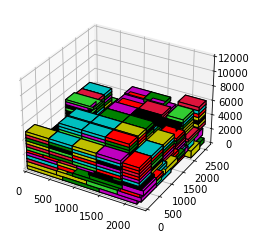

積載割合：31.26%


In [327]:
def get_filling_ratio(b):
    total_filling_volume = 0
    total_filling_ratio = 0
    
    for item in b.items:
        total_filling_volume += item.get_volume()
        
    total_filling_ratio = total_filling_volume / b.get_volume()
    return total_filling_ratio

def cuboid_data2(o, size=(3,3,3)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
        [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
        [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
        [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
        [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
        [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt2(positions,sizes=None,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data2(p, size=s) )
    return Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6), **kwargs)
    

colorList = ["crimson","limegreen","g","r","c","m","y","k"]

for i in range(len(b.items)):
    f = random.randint(0,7)
    colors.append(colorList[f])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('auto')

pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="k")
ax.add_collection3d(pc)    

ax.set_xlim([0, Packer.bins[0].width])
ax.set_ylim([0, Packer.bins[0].height])
ax.set_zlim([0, Packer.bins[0].depth])

plt.show()

for b in Packer.bins:
    print(f"積載割合：{get_filling_ratio(b)*100:.2f}%")